In [16]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
target_img_size = (256, 256)

In [18]:
cow_select=io.imread('images-to-be-tested/cow_with_selection.png')
garb_select=io.imread('images-to-be-tested/garbage_with_selection.png')

cow_orig=io.imread('images-to-be-tested/cow.jpg')
garb_orig=io.imread('images-to-be-tested/garbage.jpg')

In [19]:
# cow_resized_img=cv2.resize(cow_select,target_img_size)
cow_sel_resize=cv2.resize(cow_select,target_img_size)

# cow_sel_resized=rgba2rgb(cow_resized_img)
cow_sel_conversion=rgba2rgb(cow_sel_resize)

# cow_resized_orig=cv2.resize(cow_orig,target_img_size)
cow_resized_orig=cv2.resize(cow_orig,target_img_size)

#for colors only:
#normalized_garb_resized_img = (garb_resized_orig - np.min(garb_resized_orig)) / (np.max(garb_resized_orig) - np.min(garb_resized_orig))


# print(normalized_garb_resized_img)
# print(garb_sel_conversion)

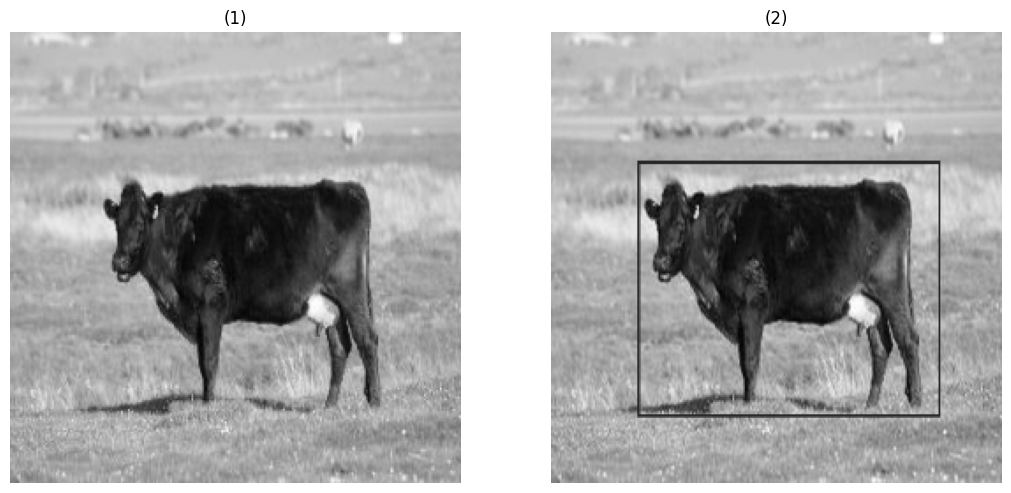

In [20]:
gray_orig_cow=rgb2gray(cow_resized_orig)
gray_sel_cow=rgb2gray(cow_sel_conversion)
show_images(images=[gray_orig_cow, gray_sel_cow])

Step 1: Finding difference between both image

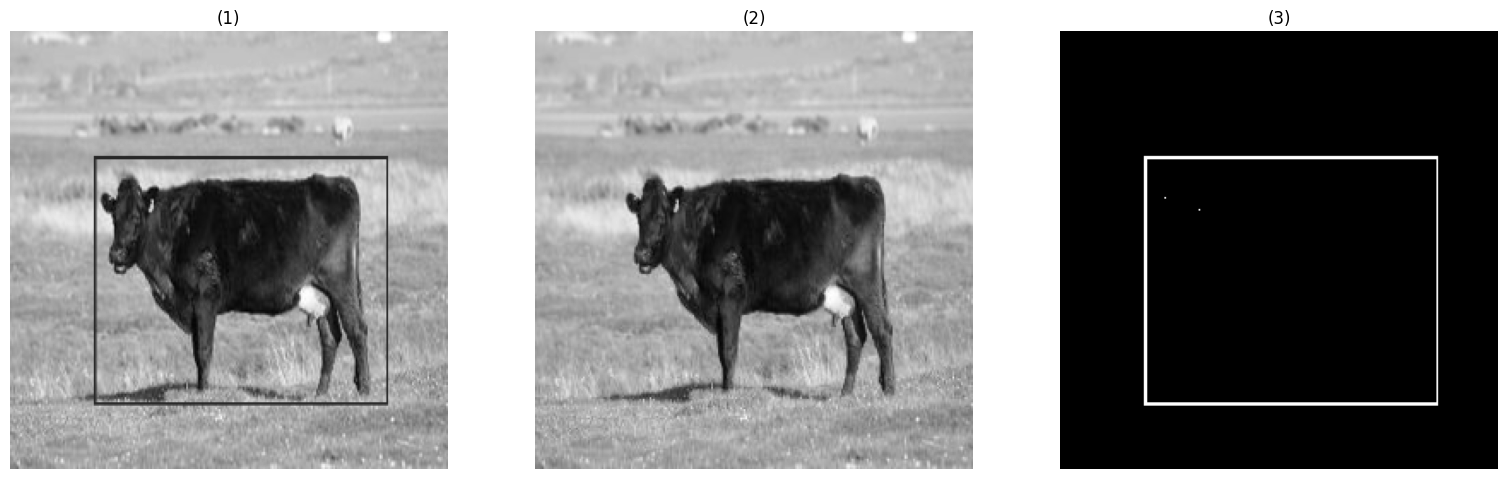

In [21]:
diff_cow = np.abs(gray_sel_cow - gray_orig_cow)

# Brightness Adjustment
result_cow=np.zeros((gray_sel_cow.shape))
result_cow[diff_cow>0.1]=1
#result_image_garb = np.where(difference_image_garb > 0.09, 1, garb_resized_orig)

show_images(images=[gray_sel_cow,gray_orig_cow,result_cow])

Step 2: Morphology:

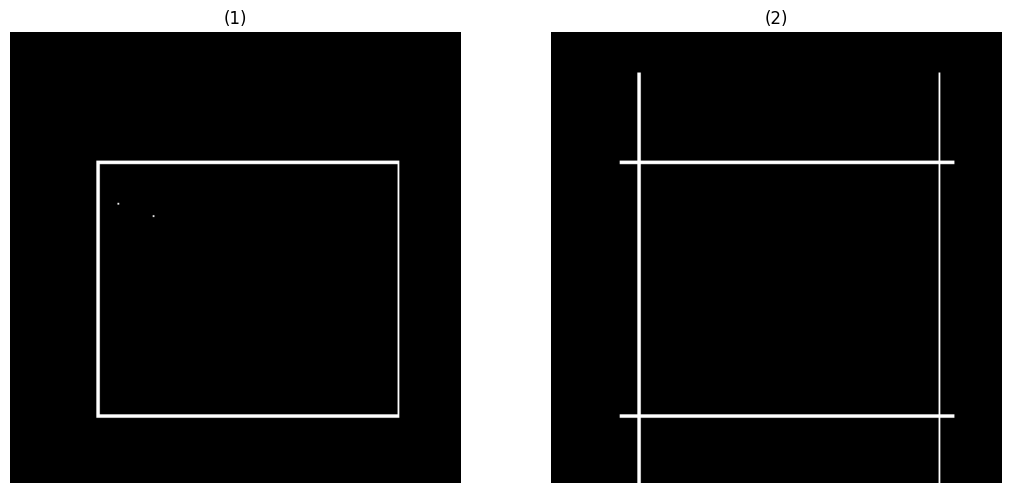

In [22]:
# we will use dilation to connect the disconnected edges:
#se=np.ones((15,15))
#se2=np.ones((3,3))
#rectangular_se = rectangle(20, 20)    # we might later need to adjust this dynamically using bounding boxes to know width and height of rectangle


se_vertical = rectangle(1, 10)
se_horizontal = rectangle(10,1)

# Apply erosion and dilation separately for vertical and horizontal lines
lines_vertical = binary_erosion(result_cow, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)


lines_horizontal = binary_erosion(result_cow, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)

# Combine the results to get connected vertical and horizontal lines
connected_lines = lines_vertical | lines_horizontal


#morp_garb=eroded_garb
morp_cow=connected_lines
#dilated_garb_2=dilation(eroded_garb,se2)
show_images(images=[result_cow,morp_cow])

Step 3: Edge detection

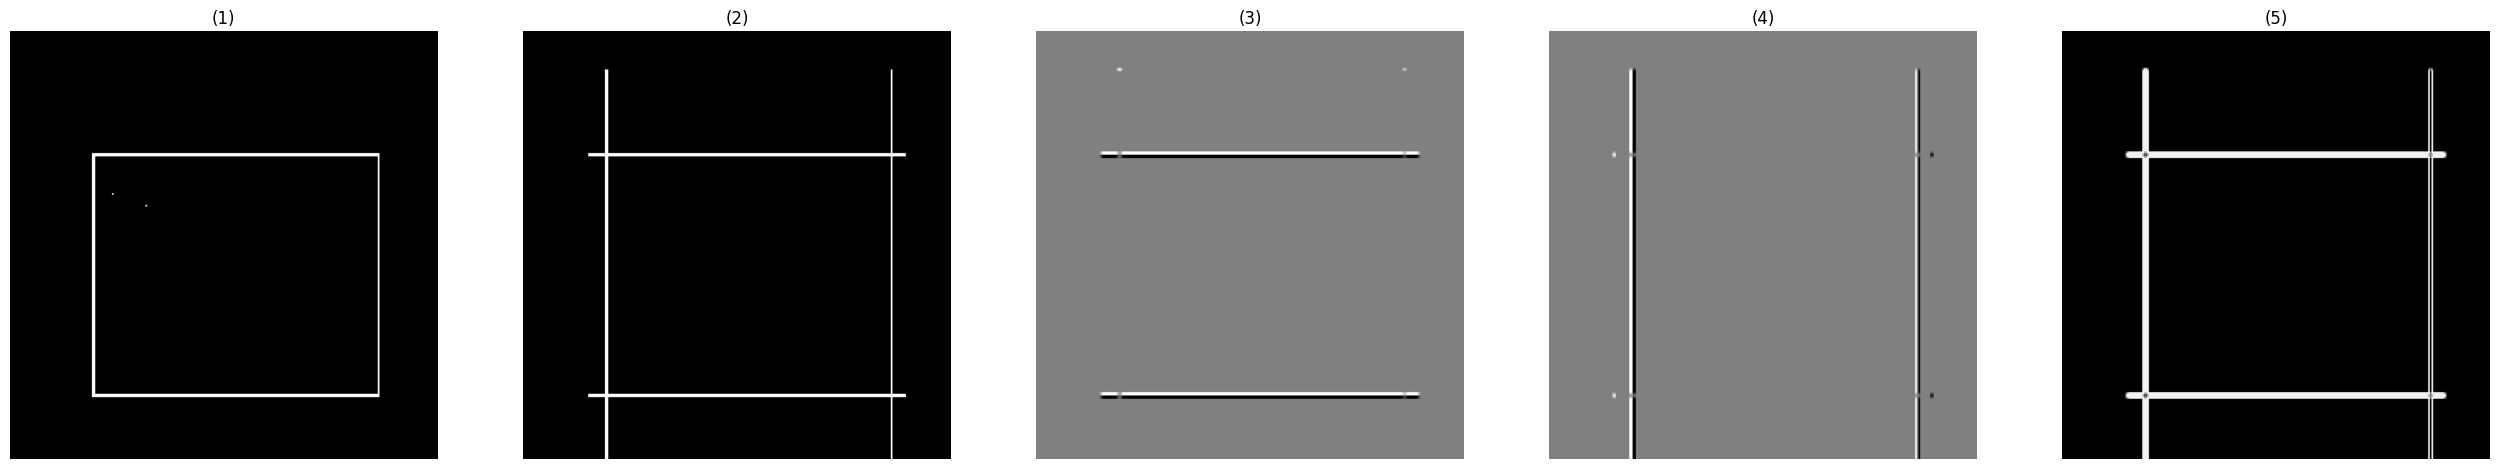

In [23]:
#sobel:
cow_sobel_x = sobel_h(morp_cow)  # Sobel operator for horizontal edges
cow_sobel_y = sobel_v(morp_cow)  # Sobel operator for vertical edges

# Combine the horizontal and vertical edges to get the magnitude
cow_sobel_magnitude = np.sqrt(cow_sobel_x**2 + cow_sobel_y**2)

show_images(images=[result_cow,morp_cow, cow_sobel_x, cow_sobel_y, cow_sobel_magnitude])

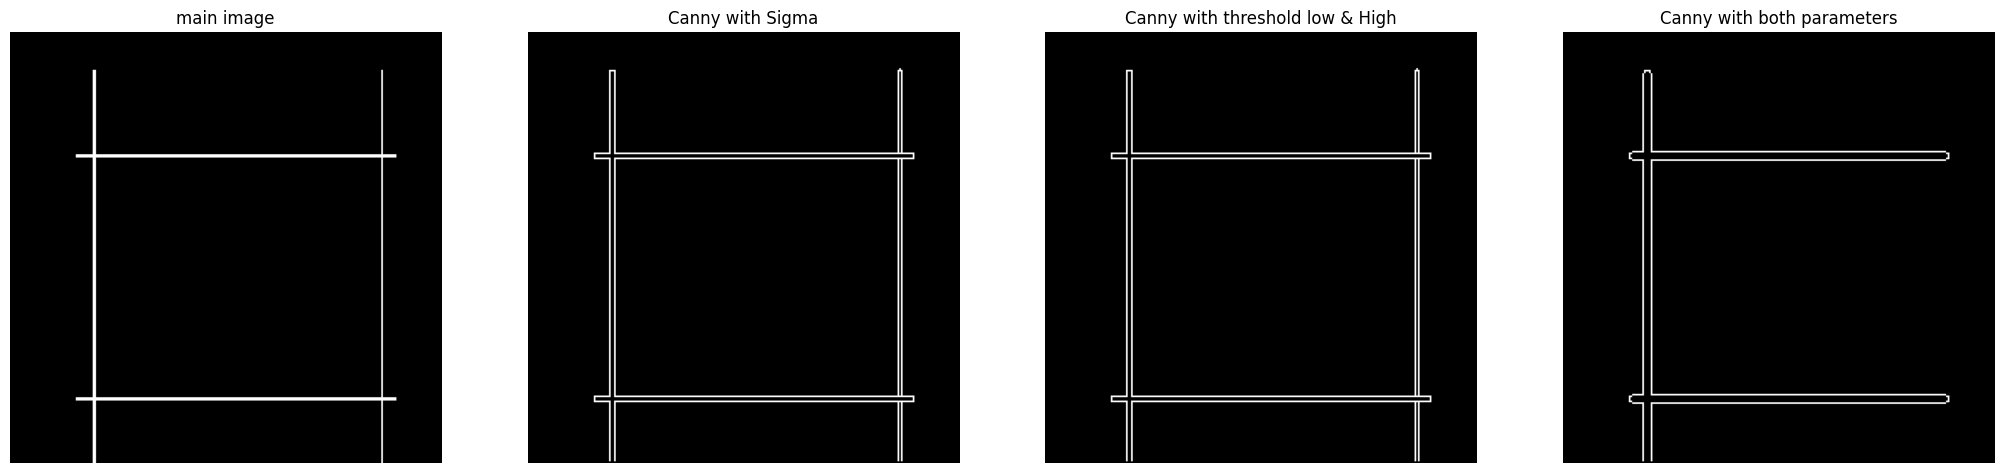

In [24]:
# Edge Detection

cow_canny_img_sigma=canny(morp_cow, sigma=1)  # increasing sigma detects stronger edges
cow_canny_with_both_threshold=canny(morp_cow, high_threshold=0.8, low_threshold=0.5)
cow_canny_with_both_par=canny(morp_cow, sigma=2, high_threshold=0.8, low_threshold=0.5)


show_images(images=[morp_cow,cow_canny_img_sigma ,cow_canny_with_both_threshold, cow_canny_with_both_par], titles=["main image","Canny with Sigma","Canny with threshold low & High", "Canny with both parameters"])


Step4: Hough Transform

https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

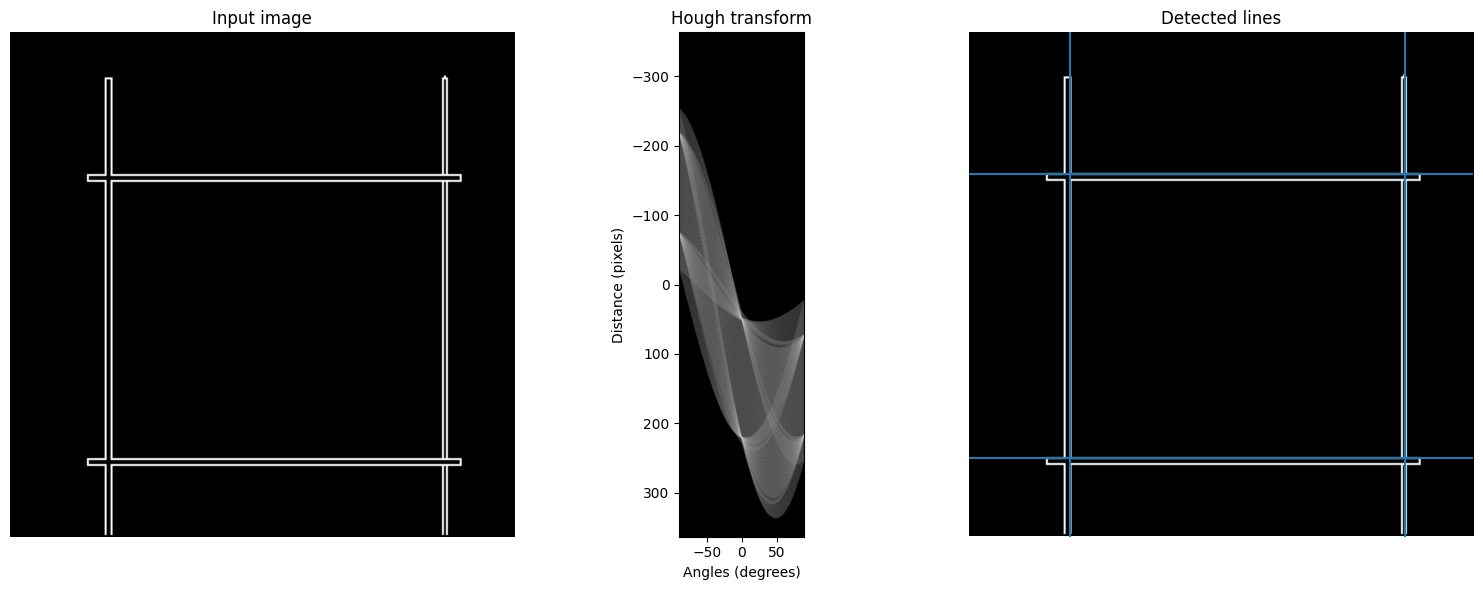

[(221.0, 72.0), (221.0, 216.0), (51.0, 72.0), (51.0, 216.0)]


In [27]:
#Given points (xi ,yi) find (R,θ)
'''
1. Parameter space is divided into accumulator cells A, all, initially, set to zero. 
2. For every point p(x,y) in image, change m in the range and calculate c. 
        C= - xm + y
3. A(m, c) = A(m, c) + 1 

At the end the value of A(mi , cj ) corresponds to the number of points that lie on the line: y = - mi x + cj

'''
image=cow_canny_img_sigma

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)


# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()


angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]


ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')



# Find intersection points
intersection_points = []


# the vertical lines will have a theta of around 0 or around 180; the horizontal lines will have a theta of around 90.
# Filter lines based on orientation
vertical_lines = []
horizontal_lines = []


for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    #lines.append((x0, y0))
    if np.degrees(angle) % 180 == 0:  # Check if the line is approximately vertical
        vertical_lines.append((x0, y0))
    elif np.degrees(angle) % 90 == 0:  # Check if the line is approximately horizontal
        horizontal_lines.append((x0, y0))

    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))


# Find intersection points between vertical and horizontal lines
for v_line in vertical_lines:
    for h_line in horizontal_lines:
        intersection_points.append((v_line[0], h_line[1]))



# print(points) :  [(68.0, 0.0), (156.0, 0.0), (-1.2491397351303002e-14, 204.0), (-4.7148901767173095e-15, 77.0)]

plt.tight_layout()
plt.show()


print(intersection_points)


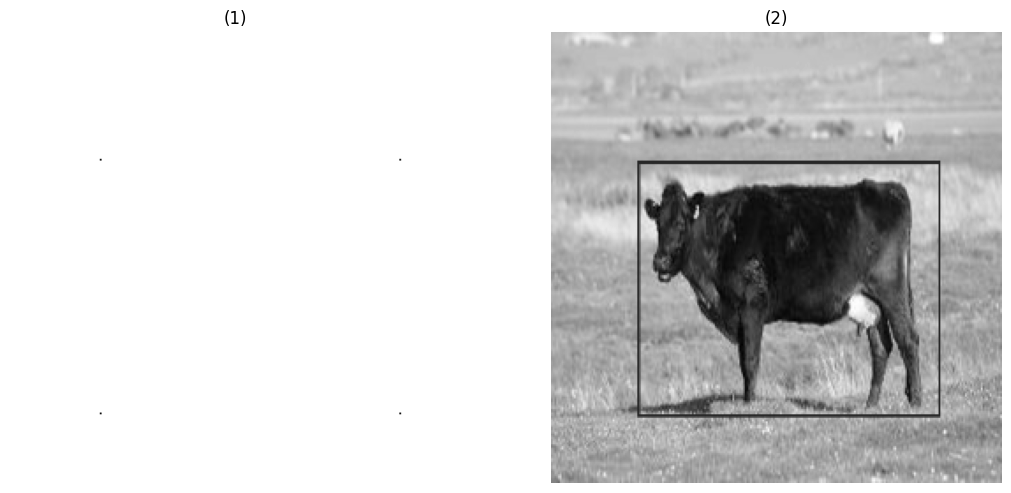

In [30]:
test_size = (256, 256)
test = np.ones((test_size))


# Coordinates of four white dots
coordinates = [(221.0, 72.0), (221.0, 216.0), (51.0, 72.0), (51.0, 216.0)]

# Convert coordinates to integers
coordinates = [(int(x), int(y)) for x, y in coordinates]

# Set the values at the coordinates to 1 (white)
for x, y in coordinates:
    test[y, x] = 0  # Note: y comes first in indexing for images

show_images(images=[test, gray_sel_cow])
